### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.preprocessing import normalize

### Loading the MNIST dataset and making sure that the sample is not biased

In [2]:
from keras.datasets import mnist

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


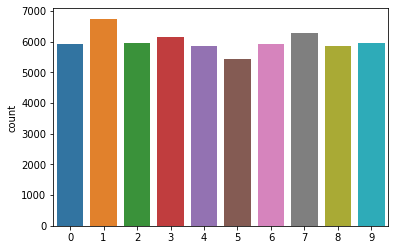

In [5]:
sns.countplot(x=train_y)

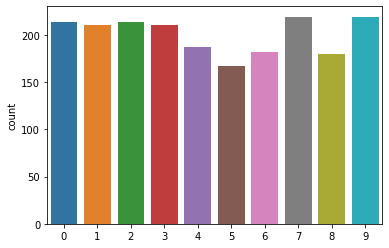

In [6]:
train_indices = np.random.choice(np.arange(train_y.shape[0]), size=2000, replace=False)
train_y = train_y[train_indices]
train_X = train_X[train_indices]
sns.countplot(x=train_y)

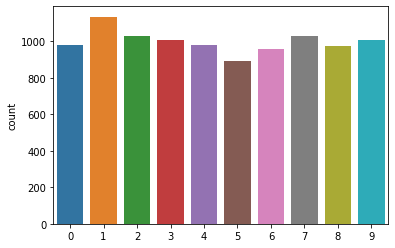

In [7]:
sns.countplot(x=test_y)

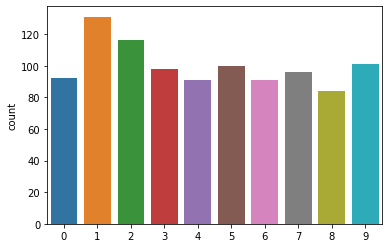

In [8]:
test_indices = np.random.choice(np.arange(test_y.shape[0]), size=1000, replace=False)
test_y = test_y[test_indices]
test_X = test_X[test_indices]
sns.countplot(x=test_y)

### Flattening the 28*28 images

In [9]:
train_X = np.reshape(train_X, (train_X.shape[0], -1))
test_X = np.reshape(test_X, (test_X.shape[0], -1))

In [10]:
train_X.shape, test_X.shape

((2000, 784), (1000, 784))

### Normalizing the input images

In [11]:
train_X = train_X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

### Define the SOM model

In [12]:
class SIMPLE_SOM: 
    
    def __init__(self, n_neurons, n_inputs, R):
        self.weights = np.random.randn(n_neurons, n_inputs)
        self.curr_weights = np.copy(self.weights)
        self.starting_lr = 1.5
        self.lr = 1.5
        self.final_lr = 0.05
        self.max_epoch = 30
        self.R = R
    
    def load_inputs(self, inputs):
        self.inputs = inputs
        
    def find_closest_neuron(self, input_arr):
        distances = np.sum(np.power(self.weights - input_arr, 2), 1)
        return np.where(distances == np.min(distances))[0][0]
    
    def find_neuron_neighbors(self, neuron_index):
        all_neurons = []
        for i in range(max(0, neuron_index - self.R), min(self.weights.shape[0], neuron_index + self.R + 1)):
            all_neurons.append(i)
        return all_neurons
    
    def update_weights(self, input_arr, neuron_index):
        neurons_indices = self.find_neuron_neighbors(neuron_index)
        for neuron in neurons_indices:
            self.curr_weights[neuron] = self.weights[neuron] + self.lr * (input_arr - self.weights[neuron])

    def process_input(self, input_arr):
        closest_neuron_index = self.find_closest_neuron(input_arr)
        self.update_weights(input_arr, closest_neuron_index)
        
    def process_all_inputs(self):
        for epoch in tqdm(range(self.max_epoch)):
            for _input in tqdm(self.inputs, leave=False):
                self.process_input(_input)
            
            self.lr = self.starting_lr - (epoch/self.max_epoch)*(self.starting_lr - self.final_lr)
            self.weights = np.copy(self.curr_weights)
            

In [16]:
som = SIMPLE_SOM(625, 784, 0)
som.load_inputs(train_X)
som.process_all_inputs()

In [17]:
results = []
for _input in train_X:
    results.append(som.find_closest_neuron(_input))

In [18]:
winner_neurons = Counter(results).keys()

In [20]:
len(winner_neurons)

23

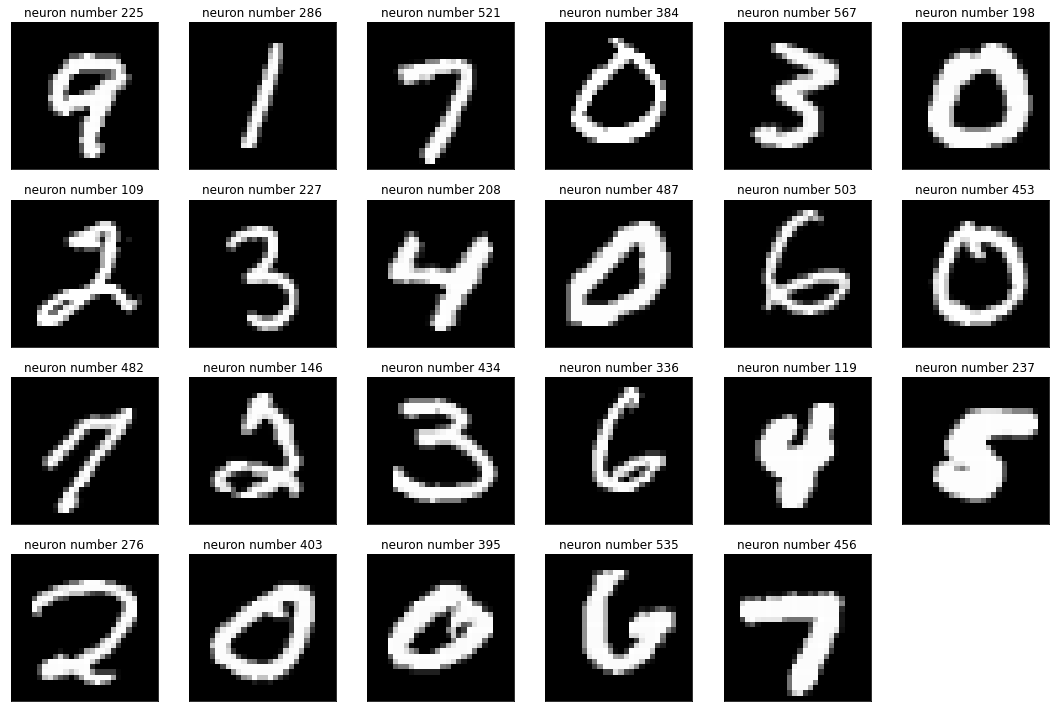

In [21]:
plt.figure(figsize=(15, 10))
for index, winner_neuron in enumerate(winner_neurons):
    ax = plt.subplot(4, 6, index + 1)
    ax.imshow(som.weights[winner_neuron].reshape([28, 28]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('neuron number {}'.format(winner_neuron))
plt.tight_layout()

In [22]:
results_for_test_data = []
for _input in tqdm(test_X):
    results_for_test_data.append(som.find_closest_neuron(_input))

In [23]:
test_y[20:30]

array([9, 5, 5, 7, 9, 2, 6, 0, 0, 2], dtype=uint8)

In [24]:
results_for_test_data[20:30]

[225, 482, 567, 482, 225, 286, 503, 453, 395, 109]

### SOM with the linear neighborhood radius of 2

In [25]:
som = SIMPLE_SOM(625, 784, 2)
som.load_inputs(train_X)
som.process_all_inputs()

In [33]:
results = []
for _input in train_X:
    results.append(som.find_closest_neuron(_input))

In [34]:
winner_neurons = Counter(results).keys()
len(winner_neurons)

293

In [36]:
winner_neurons = []
threshold = 20
for key, value in Counter(results).items():
    if value > threshold:
        winner_neurons.append(key)
len(winner_neurons)

25

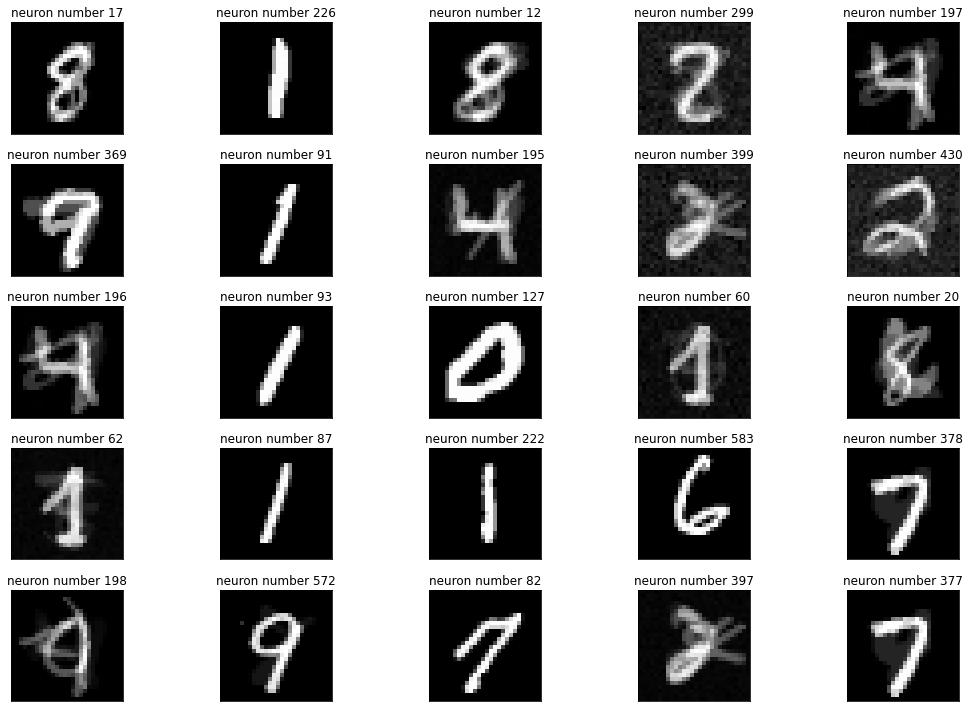

In [38]:
plt.figure(figsize=(15, 10))
for index, winner_neuron in enumerate(winner_neurons):
    ax = plt.subplot(5, 5, index + 1)
    ax.imshow(som.weights[winner_neuron].reshape([28, 28]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('neuron number {}'.format(winner_neuron))
plt.tight_layout()

In [39]:
results_for_test_data = []
for _input in tqdm(test_X):
    results_for_test_data.append(som.find_closest_neuron(_input))

In [40]:
results_for_test_data[:10]

[82, 439, 12, 369, 377, 606, 120, 231, 239, 222]

In [41]:
test_y[:10]

array([7, 2, 0, 9, 7, 2, 0, 5, 0, 1], dtype=uint8)

### SOM with square neighborhood of radius 1

In [43]:
a = np.array([
            [1, 2, 3], 
            [4, 5, 6]
])

array([[1, 2, 3],
       [4, 5, 6]])

In [58]:
class SQUARE_SOM: 
    
    def __init__(self, n_neurons, n_inputs, R):
        self.weights = np.random.randn(n_neurons, n_neurons, n_inputs)
        self.curr_weights = np.copy(self.weights)
        self.starting_lr = 1.5
        self.lr = 1.5
        self.final_lr = 0.05
        self.max_epoch = 30
        self.R = R
    
    def load_inputs(self, inputs):
        self.inputs = inputs
        
    def find_closest_neuron(self, input_arr):
        distances = np.sum(np.power(self.weights - input_arr, 2), -1)
        return np.where(distances == np.min(distances))[0][0], np.where(distances == np.min(distances))[1][0]
    
    def find_neuron_neighbors(self, x_index, y_index):
        all_neurons = []
        for i in range(max(0, x_index - self.R), min(self.weights.shape[0], x_index + self.R + 1)):
            for j in range(max(0, y_index - self.R), min(self.weights.shape[1], y_index + self.R + 1)):
                all_neurons.append((i, j))
        return all_neurons
    
    def update_weights(self, input_arr, x_index, y_index):
        neurons_indices = self.find_neuron_neighbors(x_index, y_index)
        for x, y in neurons_indices:
            self.curr_weights[x, y] = self.weights[x, y] + self.lr * (input_arr - self.weights[x, y])

    def process_input(self, input_arr):
        x_index, y_index = self.find_closest_neuron(input_arr)
        self.update_weights(input_arr, x_index, y_index)
        
    def process_all_inputs(self):
        for epoch in tqdm(range(self.max_epoch)):
            for _input in tqdm(self.inputs, leave=False):
                self.process_input(_input)
            
            self.lr = self.starting_lr - (epoch/self.max_epoch)*(self.starting_lr - self.final_lr)
            self.weights = np.copy(self.curr_weights)
            

In [59]:
som = SQUARE_SOM(25, 784, 1)
som.load_inputs(train_X)
som.process_all_inputs()

In [60]:
results = []
for _input in train_X:
    results.append(som.find_closest_neuron(_input))

In [61]:
winner_neurons = Counter(results).keys()

In [65]:
winner_neurons = []
threshold = 20
for key, value in Counter(results).items():
    if value > threshold:
        winner_neurons.append(key)
len(winner_neurons)

17

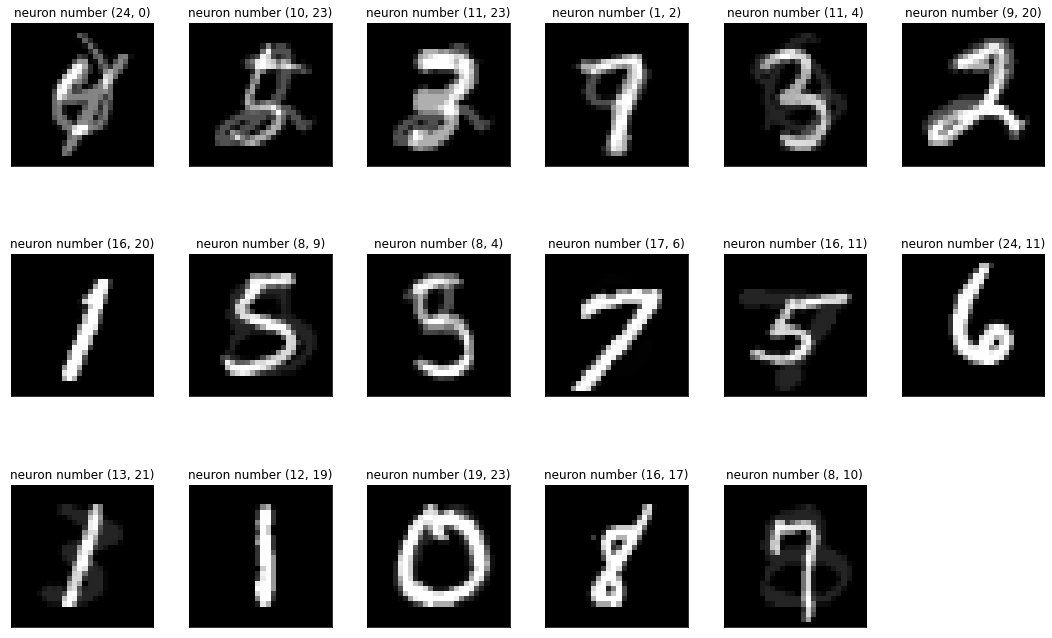

In [66]:
plt.figure(figsize=(15, 10))
for index, winner_neuron in enumerate(winner_neurons):
    ax = plt.subplot(3, 6, index + 1)
    ax.imshow(som.weights[winner_neuron].reshape([28, 28]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('neuron number {}'.format(winner_neuron))
plt.tight_layout()

In [67]:
results_for_test_data = []
for _input in tqdm(test_X):
    results_for_test_data.append(som.find_closest_neuron(_input))

In [71]:
test_y[:10]

array([7, 2, 0, 9, 7, 2, 0, 5, 0, 1], dtype=uint8)

In [72]:
results_for_test_data[:10]

[(0, 12),
 (10, 20),
 (11, 23),
 (3, 7),
 (11, 11),
 (13, 3),
 (7, 20),
 (16, 11),
 (6, 22),
 (12, 19)]